In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import animation
from abc import ABC, abstractmethod
from scipy import constants
from tqdm import tqdm
from IPython.display import clear_output
import time
import pickle

In [2]:
class InteractionEnergy(ABC):
    """
    Interface for computing interaction energies.
    """
    SORBENT = 'sorbent'
    
    @abstractmethod
    def get_energy_between(self, particle1, particle2, distance):
        """
        Get interaction energy (eV) between particle1 and particle2.

        Parameters:
            particle1, particle2: name of particles. "sorbent" for sorbent.
            distance: distance between particle1 and particle2

        Returns:
            interaction energy (eV).
        """
        pass

    @abstractmethod
    def get_energies_between(self, pairs):
        """
        Get interaction energies (eV) for each pair of particles in pairs.
        
        Parameters:
            pairs:
                tuples of particles for which to compute interaction energies.
                (name1, name2, distance)
        
        Returns:
            interaction energies (eV).
        """
        pass

In [3]:
class SimpleInteractionEnergy(InteractionEnergy):
    """
    Defines an energy scheme where interaction has a fixed energy.
    """
    def __init__(self, particles, energy_matrix):
        """
        SimpleInteractionEnergy(particles, energy_matrix)

        Parameters:
            particles: array of particle names
            energies: 
                2D array of interaction energies. energies[i][j] is the energy of particle i interacting with particle j.
                shape = (n+1)*(n+1) where n is the number of particles.
                ith column corresponds to particles[i] if i<n; corresponds to the sorbent if i==n.
                Same for rows.
                entries: energy (epsilon, eV).
        """
        energy_matrix = np.array(energy_matrix)
        if (energy_matrix.shape != (len(particles)+1, len(particles)+1)):
            raise ValueError(f"energy_matrix must have shape {(len(particles), len(particles)+1)}, got {energy_matrix.shape}")
        self.particles = {name: i for i, name in enumerate(particles)}
        self.particles[InteractionEnergy.SORBENT] = len(particles)
        self.energy_matrix = energy_matrix

    def get_energy_between(self, particle1, particle2, distance=0):
        
        idx1 = self.particles.get(particle1, -1)
        idx2 = self.particles.get(particle2, -1)
        if (idx1<0 and idx2<0):
            raise ValueError(f"{particle1} and {particle2} do not exist in the system.")
        if (idx1<0):
            raise ValueError(f"{particle1} does not exist in the system.")
        if (idx2<0):
            raise ValueError(f"{particle2} does not exist in the system.")
        
        return self.energy_matrix[idx1][idx2]

    def get_energies_between(self, pairs):
        
        return [self.get_energy_between(pair) for pair in pairs]

In [4]:
class Lattice(ABC):
    """
    Interface for representing a lattic surface
    """    
    EMPTY = 'empty'
    OCCUPIED = 'occupied'
    ALL = 'all'

    @abstractmethod
    def clear(self):
        """
        Clears the lattice in place.
        """
        pass
    
    @abstractmethod
    def get_n_sites(self, site_type):
        """
        Gets number of sites with the given type.

        Parameters:
            site_type: particle name (str or list-like)|Lattice.EMPTY|Lattice.OCCUPIED|Lattice.ALL
                Specifies the type of site using a string

        Returns:
            number of sites
        """
        pass
    
    @abstractmethod
    def draw_site(self, draw_type, rng):
        """
        Randomly draws an empty site.

        Parameters:
            draw_type: particle name (str)|Lattice.EMPTY|Lattice.OCCUPIED|Lattice.ALL
                Specifies the type of site using a string
            rng: a random number generator

        Returns:
            tuple,
            first entry: particle at site,
            sedond entry: internal representation of a site (you can understand as Site objects)
        """
        pass
    
    @abstractmethod
    def add_particle(self, site, particle):
        """
        Adds particle to site.

        Parameters:
            site: internal representation of the target site
            particle: name of particle to be added

        Returns:
            self
        """
        pass

    @abstractmethod
    def remove_particle(self, site, particle):
        """
        Adds particle to site.

        Parameters:
            site: internal representation of the target site
            particle: name of particle to remove

        Returns:
            self
        """
        pass

    @abstractmethod
    def get_energy(self, InteractionEnergy):
        """
        Computes surface energy.

        Parameters:
            InteractionEnergy: an InteractionEnergy object

        Returns:
            surface energy (eV)
        """
        pass

    def plot(self, ax, title, indexing='xy', cmap='viridis', hue=None):
        """
        Plots the current lattice.

        Parameters:
            ax: matplotlib axis object
            title: title for plot
            indexing: 'xy'|'ij'
                if 'xy', plot with image indexing
                if 'ij', plot with matrix indexing
            cmap: defines colormap
            hue: list of particle names for coloring

        Returns:
            axis object
        """

In [5]:
class SquareLattice(Lattice):
    """
    Defines a simple square lattice.
    """
    def __init__(self, n, cell_length=0):
        """
        SquareLattice(n)

        Parameters:
            n: number of cells per side
            cell_length (angstrom): length of each cell, 0 if not considering length
        """
        self.n = n
        self.lattice = np.array([[None for _ in range(n)] for _ in range(n)], dtype=object)
        self.particles = {}
        self.cell_length = cell_length

    def clear(self):
        self.lattice.fill(None)
        self.particles.clear()

    def get_sites(self, site_type=Lattice.EMPTY):
        if site_type==Lattice.ALL:
            target_sites = [(0,0) for _ in range(self.n)**2]
            count = 0
            for i in range(self.n):
                for j in range(self.n):
                    target_sites[count] = (i, j)
                    count+=1
            return target_sites
        elif site_type==Lattice.EMPTY:
            target=[None]
        elif site_type==Lattice.OCCUPIED:
            target=self.particles.keys()
        else:
            target = np.array([site_type]).flatten()
        target_sites = []
        for i in range(self.n):
            for j in range(self.n):
                if self.lattice[i][j] in target:
                    target_sites.append((i, j))
        return target_sites

    def get_n_sites(self, site_type=Lattice.EMPTY):
        if site_type==Lattice.ALL:
            return self.n**2
        return len(self.get_sites(site_type=site_type))

    def draw_site(self, draw_type=Lattice.EMPTY, rng=None):
        target_sites = self.get_sites(site_type=draw_type)
        length = len(target_sites)
        if length==0:
            return (None, None)
        if rng == None:
            draw_idx = int(np.floor(np.random.random()*length))
        else:
            draw_idx = int(np.floor(rng.random()*length))
        site = target_sites[draw_idx]
        return (self.lattice[site[0]][site[1]], site)
        
    def add_particle(self, site, particle):
        if self.lattice[site[0]][site[1]] != None:
            raise ValueError(f"{particle} cannot be added to {site} as it is still occupied by {self.lattice[site]}.")
        self.lattice[site[0]][site[1]] = particle
        if (self.particles.get(particle)!=None):
            self.particles[particle] += 1
        else:
            self.particles[particle] = 1
        return self

    def remove_particle(self, site, particle=None):
        this_particle = self.lattice[site[0]][site[1]]
        if this_particle == None:
            raise ValueError(f"Cannot remove from an empty site: {site}")
        if not particle==None and not particle==this_particle:
            raise ValueError(f"Cannot remove {particle} from site {site}, which has {this_particle}")
        self.particles[this_particle] -= 1
        if (self.particles[this_particle]) == 0:
            self.particles.pop(this_particle)
        self.lattice[site[0]][site[1]] = None
        return self

    def get_energy(self, interactionEnergy):
        """
        Computes surface energy considering only neighboring cells using 4-connectivity.
        Considers minimum image convention.

        Parameters:
            interactionEnergy: an InteractionEnergy object

        Returns:
            surface energy (eV)
        """
        energy = 0
        # we calculate total energy in one pass
        # by considering the right and bottom neighbors for each cell,
        # which incorporates all pairs of interactions and does not double count
        for i in range(self.n):
            for j in range(self.n):
                cur = self.lattice[i][j]
                if not cur==None:
                    # sorption energy
                    energy += interactionEnergy.get_energy_between(
                        cur, InteractionEnergy.SORBENT, self.cell_length
                    )
                    # sorbate interaction energy
                    nei1 = self.lattice[i][(j+1)%self.n]
                    if not nei1==None:
                        energy += interactionEnergy.get_energy_between(cur, nei1, self.cell_length)
                    nei2 = self.lattice[(i+1)%self.n][j]
                    if not nei2==None:
                        energy += interactionEnergy.get_energy_between(cur, nei2, self.cell_length)
        return energy

    def plot(self, ax, title, indexing='xy', cmap='viridis', hue=None):
        length = 1 if self.cell_length==0 else self.cell_length 
        ax.set_xlim(0, self.n*length); ax.set_ylim(0, self.n*length)
        if indexing=='ij':
            ax.set_ylim(self.n*length, 0)
        if self.cell_length==0:
            ax.set_xticks(np.arange(0, self.n+1), []); ax.set_yticks(np.arange(0, self.n+1), [])
        else:
            ax.set_xticks(np.arange(0, (self.n+1)*length, length)); ax.set_yticks(np.arange(0, (self.n+1)*length, length))
            ax.set_xlabel(r'x ($\AA$)' if indexing=='xy' else r'y ($\AA$)')
            ax.set_ylabel(r'y ($\AA$)' if indexing=='xy' else r'x ($\AA$)')
        ax.grid()
        ax.set_aspect('equal')

        if hue==None:
            colors = plt.get_cmap(cmap, len(self.particles))
            cmap = {particle: colors(i) for i, particle in enumerate(self.particles.keys())}
        else:
            colors = plt.get_cmap(cmap, len(hue))
            cmap = {particle: colors(i) for i, particle in enumerate(hue)}
        for i in range(self.n):
            for j in range(self.n):
                this_particle = self.lattice[i][j]
                if (this_particle!=None):
                    x = length/2+length*i if indexing=='xy' else length/2+length*j
                    y = length/2+length*j if indexing=='xy' else length/2+length*i
                    ax.add_patch(
                        plt.Circle(
                            (x, y),
                            radius=length/2*0.5,
                            color=cmap[this_particle],
                            alpha=0.7
                        )
                    )
                    ax.text(x, y, f"${this_particle}$", ha='center', va='center')
        ax.set_title(title)
        return ax

[['C' None None None]
 [None None 'A_2' None]
 [None None None None]
 [None None None 'B']]


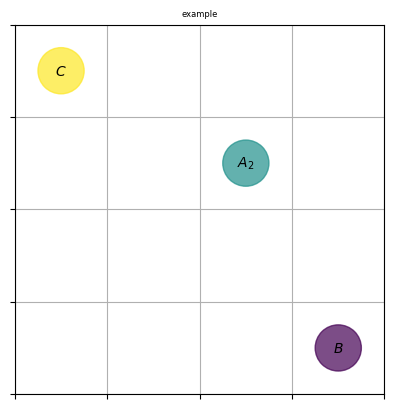

In [6]:
lattice = SquareLattice(4)
lattice.add_particle((1,2), 'A_2')
lattice.add_particle((3,3), 'B')
lattice.add_particle((0,0), 'C')
fig, ax = plt.subplots()
print(lattice.lattice)
lattice.plot(ax, "example", indexing='ij', hue=['B', 'A_2', 'C'])
ax.title.set_size(6)

In [7]:
class GrandCanonicalEnsemble:
    """
    Defines a grand canonical ensemble for Monte Carlo simulation
    """    
    def __init__(self, particles, mus, temp, lattice, interactionEnergy, rng):
        """
        GrandCanonicalEnsemble(particles, mus, temp, lattice, interactionEnergy, seed)

        Parameters:
            particels: array of particle names
            mus (eV/mol): array of chemical potentials
            temp (K): simulation temperature
            lattice: a Lattice object that defines the simulation lattice
            interactionEnergy: an InteractionEnergy object that defines interaction energies
            rng: random number generator
        """
        self.lattice = lattice
        self.interactionEnergy = interactionEnergy
        self.temp = temp
        self.beta = 1/(constants.k/constants.eV*temp) # eV^{-1}
        self.particles = particles
        self.mus = mus
        self.mu_dict = {particle: mu for particle, mu in zip(particles, mus)}
        self.rng = rng

    def reseed(seed):
        """
        Reseeds the current instance
        """
        self.rng = np.random.default_rng(seed)
    
    def attempt_add(self, particle, site):
        """
        Attempt adding a particle at site

        Parameters:
            particle: name of particle to add
            site: internal representation of a site
            
        Side effects: Updates self.lattice in place with added particle

        Returns:
            True if added successfully, False otherwise
        """
        Na = self.lattice.get_n_sites(Lattice.EMPTY)
        Ns = self.lattice.get_n_sites(particle)
        mu = self.mu_dict[particle]

        self.lattice.add_particle(site, particle)
        updated_surface_energy = self.lattice.get_energy(self.interactionEnergy)
        delta_e = updated_surface_energy - self.current_energy
        acc = min(1, (Na)/(Ns+1)*np.exp(-self.beta*(delta_e-mu)))
        prob = self.rng.random()
        if (prob<acc):
            self.current_energy = updated_surface_energy
            return True
        else:
            self.lattice.remove_particle(site, particle)
            return False

    def attempt_remove(self, particle, site):
        """
        Attempt removing a particle at site

        Parameters:
            particle: name of particle to add
            site: internal representation of a site

        Side effects: Updates self.lattice in place with removed particle

        Returns:
            True if removed successfully, False otherwise
        """
        Na = self.lattice.get_n_sites(Lattice.EMPTY)
        Ns = self.lattice.get_n_sites(particle)
        mu = self.mu_dict[particle]

        self.lattice.remove_particle(site, particle)
        updated_surface_energy = self.lattice.get_energy(self.interactionEnergy)
        delta_e = updated_surface_energy - self.current_energy
        acc = min(1, Ns/(Na+1)*np.exp(-self.beta*(delta_e+mu)))
        prob = self.rng.random()
        if (prob<acc):
            self.current_energy = updated_surface_energy
            return True
        else:
            self.lattice.add_particle(site, particle)
            return False

    def generate_mc_simulator(self, move_probs=[0.5, 0.5], particle_probs=[0.5, 0.5]):
        """
        Creates a Monte Carlo simulator.

        Parameters:
            move_probs: array of probabilities. [P(add), P(remove)]
            particle_probs: array of probabilities for operation on each particles.

        Returns: self
        """
        self.lattice.clear()
        self.current_energy = self.lattice.get_energy(self.interactionEnergy)
        move_probs = np.cumsum(move_probs)
        particle_probs = np.cumsum(particle_probs)

        def simulator():
            prob = self.rng.random()
            # add
            if prob<move_probs[0]:
                particle_idx = int(self.rng.random()*len(self.particles))
                _, site = self.lattice.draw_site(draw_type=Lattice.EMPTY, rng=self.rng)
                if not site==None:
                    self.attempt_add(self.particles[particle_idx], site)
            # remove
            else:
                particle, site = self.lattice.draw_site(draw_type=Lattice.OCCUPIED, rng=self.rng)
                if not site==None:
                    self.attempt_remove(particle, site)
        self.step = simulator
        return self

    def run_mc(self, n_steps=200, move_probs=[0.5, 0.5], particle_probs=[0.5, 0.5], verbose=False, progress=False):
        """
        Runs the Monte Carlo simulation and store the results.
        Updates self.coverages to the coverage of each particle at each step.

        Parameters:
            n_steps: steps to run
            move_probs: array of probabilities. [P(add), P(remove)]
            particle_probs: array of probabilities for operation on each particles.
            verbose: sets verbose output
            progress: shows progress bar

        Returns: self
        """
        self.coverages = np.zeros((n_steps, len(self.particles)))
        self.generate_mc_simulator(move_probs=move_probs, particle_probs=particle_probs)
        if verbose or not progress:
            itr = range(n_steps)
        else:
            itr = tqdm(range(n_steps))
        for step in itr:
            self.step()
            for j in range(self.coverages.shape[1]):
                self.coverages[step][j] = self.lattice.get_n_sites(self.particles[j])/self.lattice.get_n_sites(Lattice.ALL)
            if verbose:
                clear_output(wait=True)
                print(f"Step {step}, coverages: {self.coverages[step]}")
                print(self.lattice.lattice, end='\r', flush=True)
                time.sleep(0.05)
        self.step = None
        return self

    def run_mc_animate(self, file_name, save_steps=10, n_itr=20, move_probs=[0.5, 0.5], particle_probs=[0.5, 0.5], progress=False, **kwargs):
        """
        Runs the Monte Carlo simulation and store the results.
        Updates self.coverages to the coverage of each particle at each step.

        Parameters:
            file_name: name of file to save the animation
            save_steps: steps to save in animation
            n_itr: iterations of save to run
                Total number of steps is save_steps*n_itr
            move_probs: array of probabilities. [P(add), P(remove)]
            particle_probs: array of probabilities for operation on each particles.
            progress: shows progress bar
            **kwargs: additional keyword arguments passed to Lattice.plot()

        Returns: self
        """
        n_steps = n_itr*save_steps
        self.coverages = np.zeros((n_steps, len(self.particles)))
        self.generate_mc_simulator(move_probs=move_probs, particle_probs=particle_probs)
        
        fig, ax = plt.subplots()

        if progress:
            progress_bar = tqdm(total=n_itr, desc="Animating")
        def update(frame):
            if progress:
                progress_bar.update(1)
            ax.clear()
            for step in range(save_steps):
                self.step()
                for j in range(self.coverages.shape[1]):
                    self.coverages[save_steps*frame+step][j] = self.lattice.get_n_sites(self.particles[j])/self.lattice.get_n_sites(Lattice.ALL)
            self.lattice.plot(ax, f"Step {save_steps*frame+step+1}", **kwargs)
            return ax

        anim = animation.FuncAnimation(fig, update, frames=n_itr, blit=False)
        anim.save(file_name, fps=20, dpi=200)
        self.step = None
        return self

# Sanity Check

In [334]:
particles = ['A', 'B']
mus = [-0.2, -0.1]
temp = 298
n = 6
move_probs = [0.5, 0.5]
particle_probs = [0.5, 0.5]

In [335]:
#          A  B  sorbent
# A
# B
# sorbent
simple_energy_mat = np.array([
    [0,    0,    -0.1],
    [0,    0,    -0.1],
    [-0.1, -0.1, 0   ]
])
simpleInteraction = SimpleInteractionEnergy(particles, simple_energy_mat)

In [336]:
squareLattice = SquareLattice(n)
ensemble = GrandCanonicalEnsemble(
    particles,
    mus,
    temp,
    squareLattice,
    simpleInteraction,
    np.random.default_rng(114514)
)

In [337]:
ensemble.run_mc(n_steps=200, move_probs=move_probs, particle_probs=particle_probs, verbose=True)

Step 199, coverages: [0.02777778 0.30555556]
[[None 'B' None None None None]
 [None None 'A' 'B' None None]
 ['B' None 'B' 'B' None None]
 [None None 'B' None 'B' 'B']
 [None None None None None 'B']
 [None None None None 'B' 'B']]

In [291]:
with open('sanity_check.pickle', 'wb') as file:
    pickle.dump(ensemble, file)

Animating: 101it [00:09, 10.87it/s]                                                                                    


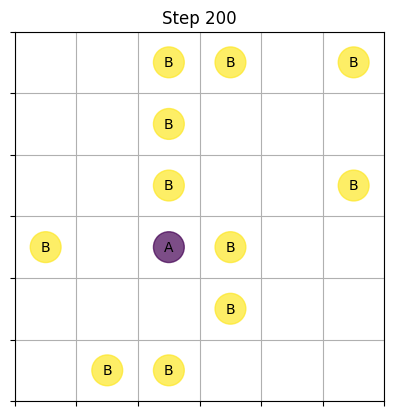

In [338]:
ensemble.run_mc_animate("toy_example.mp4", save_steps=2, n_itr=100, move_probs=move_probs, particle_probs=particle_probs, progress=True, indexing='ij', hue=['A', 'B'])

# Example system

In [8]:
def get_mean_coverages(ensembles, steps=1000):
    """
    Computes mean coverages

    Parameters:
        ensembles: 2d array of Ensemble objects, must have homogeneous coverages array
        steps: number of steps counting from the last step to compute the mean coverages

    Returns:
        array of mean coverages for each species, and the total mean coverage
    """
    rows = len(ensembles)
    cols = len(ensembles[0])
    coverages = []
    for i in range(0, rows):
        row_cov = []
        for j in range(0, cols):
            row_cov.append(ensembles[i][j].coverages[-steps:, :])
        coverages.append(row_cov)
    coverages = np.array(coverages)
    coverages = np.mean(coverages, axis=2)
    coverages = [coverages[:, :, i] for i in range(coverages.shape[-1])]
    coverages.append(np.sum(coverages, axis=0))
    return coverages

In [9]:
def plot_phase_diagrams(ensembles, ax, x, y, x_lab='', y_lab='', c_lab='', steps=1000, values=True, **kwargs):
    """
    Plots phase diagrams.
    
    Parameters:
        ensembles: 2d array of Ensemble objects, must have homogeneous coverages array
        ax: array of axis objects
        x: x axis values
        y: x axis values
        x_lab: x axis labels
        y_lab: y axis labels
        c_lab: color bar label
        steps: number of steps counting from the last step to compute the mean coverages
        values: whether to show values on the grid
        **kwargs: keyword arguments passed to pcolormesh

    Returns:
        the last pcolormesh object
    """
    mean_coverages = get_mean_coverages(ensembles, steps)
    particles = ensembles[0][0].particles
    for i in range(len(ax)):
        g = ax[i].pcolormesh(x, y, mean_coverages[i].T, **kwargs)
        if values:
            for row in range(len(mean_coverages[i])):
                for col in range(len(mean_coverages[i][0])):
                    ax[i].text(x[row], y[col], np.round(mean_coverages[i][row][col], 1), ha='center', va='center', size=6)
        if i == len(mean_coverages)-1:
            ax[i].set_title(r'$\langle \theta \rangle$')    
            plt.colorbar(g, ax=ax[i], location='right', fraction=0.1, label=c_lab)
        else:
            ax[i].set_title(rf'$\langle \theta_{{ {particles[i]} }} \rangle$')
        ax[i].set_xlabel(x_lab)
        if i == 0:
            ax[i].set_ylabel(y_lab)
        else:
            ax[i].set_yticks([])
    return g

In [343]:
particles = ['A', 'B']
simple_energy_mat = np.array([
    [0,    0,    -0.1],
    [0,    0,    -0.1],
    [-0.1, -0.1, 0   ]
])
simpleInteraction = SimpleInteractionEnergy(particles, simple_energy_mat)

n = 4
n_steps = 10000
move_probs = [0.5, 0.5]
particle_probs = [0.5, 0.5]
mu_B = -0.1

mus_A = np.linspace(-0.2, 0, 7)
Ts = np.linspace(0.001, 0.019, 7)*constants.eV/constants.k
ensembles = [[None for _ in range(7)] for _ in range(7)]

rng = np.random.default_rng(42)
progress = tqdm(total=7*7)
for i, mu_A in enumerate(mus_A):
    for j, temp in enumerate(Ts):
        squareLattice = SquareLattice(n)
        ensemble = GrandCanonicalEnsemble(
            particles,
            [mu_A, mu_B],
            temp,
            squareLattice,
            simpleInteraction,
            rng
        )
        ensemble.run_mc(n_steps=n_steps, move_probs=move_probs, particle_probs=particle_probs)
        ensembles[i][j] = ensemble
        progress.update(1)

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [01:31<00:00,  1.80s/it]

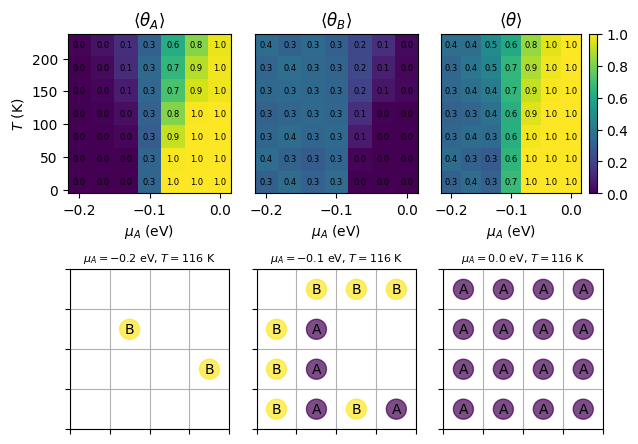

In [355]:
fig, axs = plt.subplots(2, 3, figsize=(6.5, 4.5))

g = plot_phase_diagrams(ensembles, [axs[0][0], axs[0][1], axs[0][2]], mus_A, Ts, r"$\mu_A$ (eV)", "$T$ (K)", cmap='viridis', vmin=0, vmax=1)

ensembles[0][3].lattice.plot(axs[1][0], rf'$\mu_A = {mus_A[0]}$ eV, $T = {Ts[3]:.0f}$ K', indexing='ij', hue=['A', 'B'])
axs[1][0].title.set_size(8)
ensembles[3][3].lattice.plot(axs[1][1], rf'$\mu_A = {mus_A[3]}$ eV, $T = {Ts[3]:.0f}$ K', indexing='ij', hue=['A', 'B'])
axs[1][1].title.set_size(8)
ensembles[6][3].lattice.plot(axs[1][2], rf'$\mu_A = {mus_A[6]}$ eV, $T = {Ts[3]:.0f}$ K', indexing='ij', hue=['A', 'B'])
axs[1][2].title.set_size(8)

plt.tight_layout()
fig.savefig('example_phase_diagram.png', dpi=210)

# Exploring adsorption of $N_2$ and $H_2$

In [10]:
def mc_haber_with_energy(energy_mat):
    """
    Runs Monte Carlo simulation with energy_mat

    Parameters:
        energy_mat: interaction energy matrix between H2 and N2

    Returns:
        2d array of ensembles
    """
    
    particles = ['H_2', 'N_2']
    simpleInteraction = SimpleInteractionEnergy(particles, energy_mat)
    
    n = 4
    n_steps = 10000
    move_probs = [0.5, 0.5]
    particle_probs = [0.5, 0.5]
    mu_N2 = -0.1
    
    mus_H2 = np.linspace(-0.2, 0, 7)
    Ts = np.linspace(0.001, 0.019, 7)*constants.eV/constants.k
    ensembles = [[None for _ in range(7)] for _ in range(7)]

    rng = np.random.default_rng(114514)
    progress_bar = tqdm(total=len(mus_H2)*len(Ts))
    for i, mu_H2 in enumerate(mus_H2):
        for j, temp in enumerate(Ts):
            squareLattice = SquareLattice(n)
            ensemble = GrandCanonicalEnsemble(
                particles,
                [mu_H2, mu_N2],
                temp,
                squareLattice,
                simpleInteraction,
                rng
            )
            ensemble.run_mc(n_steps=n_steps, move_probs=move_probs, particle_probs=particle_probs)
            ensembles[i][j] = ensemble
            progress_bar.update(1)
    return ensembles

In [11]:
#         H2   N2   sorbent
# H2
# N2
# sorbent
ideal_mixture = np.array([
    [0,    0,    -0.1],
    [0,    0,    -0.1],
    [-0.1, -0.1, 0   ]
])
repulsive = np.array([
    [0.05, 0.05, -0.1],
    [0.05, 0.05, -0.1],
    [-0.1, -0.1, 0   ]
])
attractive = np.array([
    [-0.05,-0.05,-0.1],
    [-0.05,-0.05,-0.1],
    [-0.1, -0.1, 0   ]
])
immiscible = np.array([
    [-0.05,0.05, -0.1],
    [0.05, -0.05,-0.1],
    [-0.1, -0.1, 0   ]
])
dissolve_unlike = np.array([
    [0.05, -0.05,-0.1],
    [-0.05,0.05, -0.1],
    [-0.1, -0.1, 0   ]
])
energy_mats = [ideal_mixture, repulsive, attractive, immiscible, dissolve_unlike]
schemes = ['Ideal mixture', 'Repulsive', 'Attractive', 'Immiscible', 'Dissolve unlike']

In [12]:
ensembles_arr = []
for i, energy_mat in enumerate(energy_mats):
    ensembles_arr.append(mc_haber_with_energy(energy_mat))

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:51<00:00,  1.06s/it]


In [13]:
with open('ensembles_arr.pickle', 'wb') as file:
    pickle.dump(ensembles_arr, file)

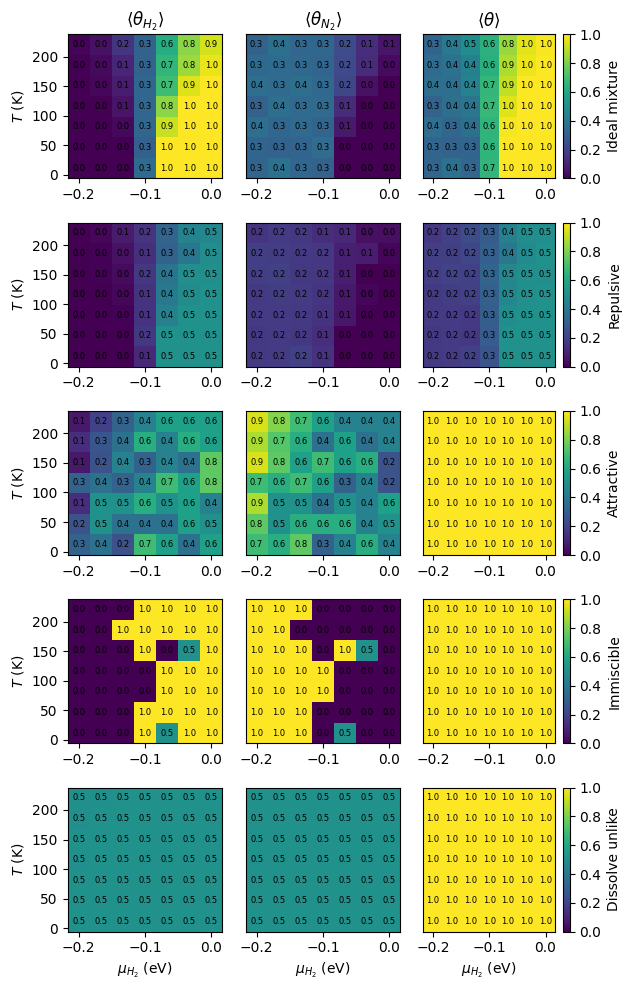

In [14]:
fig, axs = plt.subplots(5, 3, figsize=(6.5, 10))
mus_H2 = np.linspace(-0.2, 0, 7)
Ts = np.linspace(0.001, 0.019, 7)*constants.eV/constants.k
for i in range(5):
    plot_phase_diagrams(
        ensembles_arr[i],
        [axs[i][0], axs[i][1], axs[i][2]],
        mus_H2,
        Ts,
        x_lab=r"$\mu_{H_2}$ (eV)",
        y_lab="$T$ (K)",
        c_lab=schemes[i],
        cmap='viridis',
        vmin=0,
        vmax=1
    )
    if i!=0:
        axs[i][0].set_title('');axs[i][1].set_title('');axs[i][2].set_title('')
    if i!=4:
        axs[i][0].set_xlabel('');axs[i][1].set_xlabel('');axs[i][2].set_xlabel('')
plt.tight_layout()
fig.savefig('haber_exploration_phase_diagrams.png', dpi=210)

## Discussion of adsorption behaviors

$$N_2 + 3H_2 \rightarrow 2NH_3$$
In all simulations, we set the adsorption energy of $H_2$ and $N_2$ to $-0.1eV/mol$.

- **Ideal Mixture**\
    In this model, the interactions between adsorbed $H_2$ and $N_2$ are ignored.
    - *temperature*: At a given $\mu_{H_2}$, both $\theta_{H_2}$ and $\theta_{N_2}$ decreases, leading to a decrease in $\theta$. This is expected, as the gas phase has greater entropy, and an increase in temperature favors the gain in entropy by the gas phase over the gain in enthalpy by the adsorbed phase.
    - *$\mu_{H_2}$*: At a given temperature, as $\mu_{H_2}$ increases, $\theta_{H_2}$ increases, while $\theta_{N_2}$ decreases. This is expected, as species seek to minimize their chemical potentials, and a higher chemical potential in the gas phase would drive $H_2$ into the adsorbed phase. This higher tendency to bind the surface would exclude $N_2$ from binding, leading to a decrease in $\theta_{N_2}$. Since $\mu = \mu^0 + RTln(P/P^0)$ for an ideal gas, a higher $\mu$ means a higher pressure. It makes sense that under higher $H_2$ pressure, more $H_2$ would bind the surface, which takes the place of $N_2$.
    - *Optimal condition*: The optimal condition for ammonia synthesis should ideally have a ratio of 3:1 for adsorbed $H_2$:$N_2$, and the two species should be near each other to react. The total coverage is maximized at low temperature and high $\mu_{H_2}$, but high $\mu_{H_2}$ also excludes $N_2$ from binding. The optimal condition seems to be $-0.08 eV/mol < \mu_{H_2} < -0.05 eV/mol$ and $125 K < T < 250 K$, where coverage of $H_2$ is around 0.7 and $N_2$ around 0.2. Although the total coverage is less than 1, this optimizes the ratio of $H_2$:$N_2$.

- **Repulsive**\
    In this model, the interaction energies between adsorbed $H_2$ and $N_2$ are all positive, indicating pairwise repulsion.
    - *temperature*: With increasing temperature, both $\theta_{H_2}$ and $\theta_{N_2}$ and the total coverage still decreases, but the effect is smaller or unobservable compared with the ideal mixture.
    - *$\mu_{H_2}$*: With increasing $\mu_{H_2}$, $\theta_{H_2}$ and $\theta$ increases, while $\theta_{N_2}$ decreases. This is expected with higher tendency of $H_2$ to leave the gas phase with higher $\mu$. With the repulsive interaction between $H_2$ and $N_2$, more adsorbed $H_2$ would lead to a greater decrease in $N_2$ coverage compared to the ideal mixture.
    - *Compared* with the ideal mixture, $\theta_{H_2}$, $\theta_{N_2}$ and $\theta$ all become smaller with the same $T$ and $\mu_{H_2}$. This is expected, as repulsion between adsorbed particles would favor the gas phase for both $H_2$ and $N_2$. In the lattice with $\mu_{H_2}=0$, we see that the hydrogen molecules arrange themselves alternately such that no two molecules can interact with each other. Thus, the maximum coverage achieved is 0.5.
    - *Optimal condition*: When $\mu_{H_2} > -0.05 eV/mol$, the total coverage is maximized. However, almost no nitrogen is adsorbed under this condition, which would not be ideal for the synthesis of ammonia. When $-0.08 eV/mol < \mu_{H_2} < -0.05 eV/mol$ and $60K<T<175K$, $\theta_{H_2}$ is around 0.4 and $\theta_{N_2}$ is around 0.1, which seems to be the best condition with a ratio of $H_2$:$N_2$ around 3:1. Of course, the coverages are quite low in this condition, which could be argued against it. Further experiment is needed to determine if balanced but low adsorption of both molecules is preferred over high adsorption of $H_2$ but low adsorption of $N_2$.

- **Attractive**\
    In this model, the interaction energies between adsorbed $H_2$ and $N_2$ are all negative, indicating pairwise attraction.
    - *temperature*: The effect of temperature seems to be mixed and not prominent. When $\mu_{H_2}>-0.15 eV/mol$, temperature doesn't seem to have any directional impact on both $\theta_{H_2}$ and $\theta_{N_2}$. Interestingly, when $\mu_{H_2}<-0.15 eV/mol$, as temperature increases, $\theta_{H_2}$ decreases as expected, but $\theta_{N_2}$ fluctuates and even seems to increase. This might be explained by the greater statistical chance of $N_2$ binding with $\mu_{N_2}>\mu_{H_2}$. Assuming the surface is always saturated by the network of molecules, which is indicated by the 100% total coverage, simply more $N_2$ is available to bind and is expected to have higher coverage.
    - *$\mu_{H_2}$*: As *$\mu_{H_2}$* increases, $\theta_{H_2}$ increases while $\theta_{N_2}$ decreases, which is as expected as $H_2$ gains larger tendancy to bind.
    - *Compared* with the ideal mixture, $\theta$ and $\theta_{N_2}$ become larger with the same $T$ and $\mu_{H_2}$, while $\theta_{H_2}$ is larger when $\mu_{H_2} < \mu_{N_2}$, but smaller when $\mu_{H_2} > \mu_{N_2}$. This is expected, as atraction between adsorbed molecules would favor the adsorbed phase. And due to the attraction between $H_2$ and $N_2$, more $N_2$ can bind even when $H_2$ is dominant. In the lattice we see a mixture of fully occupied $H_2$ and $N_2$ due to their attraction.
    - *Optimal condition*: $\mu_{H_2}>-0.05 eV/mol$ under all temperatures sampled seems to be the best condition, where $\theta_{H_2}$ is around 0.6, slightly larger than $\theta_{N_2}$ which is around 0.4, with a total coverage of 1.

- **Immiscible**\
    In this model, the interactions between the same species are negative (attractive), while the interaction between $H_2$ and $N_2$ is positive (repulsive).
    - *temperature*: It seems that no effect of temperature can be concluded from the phase diagrams. This might be because the attraction between the same species is strong enough that thermal energy cannot break them, so coverage is determined solely by chemical potentials. In particular, when $\mu_{H_2}=\mu_{N_2}=-0.1 eV/mol$, $H_2$ occupies all the sites half of the time. Since the energetics of $H_2$ and $N_2$ are perfectly symmetrical in this case, we would expect such an even distribution if temperature has no effect.
    - *$\mu_{H_2}$*: When $\mu_{H_2}<\mu_{N_2}$, the lattice is fully occupied by $N_2$. When $\mu_{H_2}>\mu_{N_2}$, it is fully occupied by $H_2$. This is as expected. Since the two species attract like and repell unlike, whichever species with the larger $\mu$, and therefore larger tendancy to bind, will win and repell the other.
    - *Optimal condition*: $\mu_{H_2}=\mu_{N_2}=-0.1eV/mol$ seems to be the best condition, where each species has equal chance to dominate. However, this situation is non-ideal under all conditions, since the two species would hardly react if they repell each other. In the lattice we only observe one species under all conditions.

- **Dissolve unlike**\
    In this model, the interactions between the same species are positive (repulsive), while the interaction between $H_2$ and $N_2$ is negative (attractive).
    - Under this model, the full coverage remains 1 with $H_2$ and $N_2$ equally adsorbed in all conditions. The high coverage can be understood as the attraction network dominates over thermal fluctuation. The equal partition can be understood as the attraction network needs both species to form. In the lattice we see that $H_2$ and $N_2$ are arranged alternately such that the four neighbors of one species are the other species.
    - *Optimal condition*: there is no difference between all the conditions sampled.

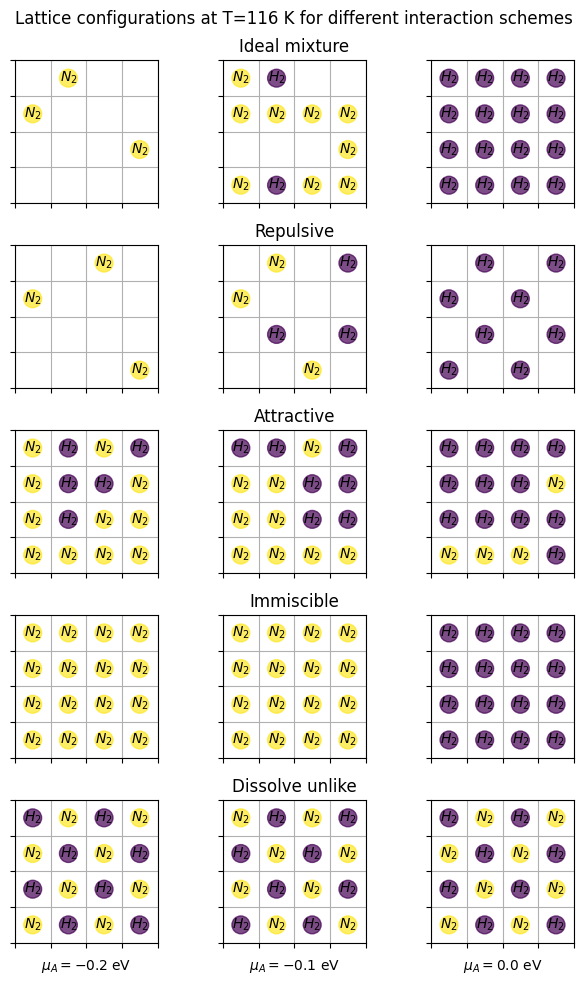

In [16]:
fig, axs = plt.subplots(5, 3, figsize=(6.5, 10))
mus_H2 = np.linspace(-0.2, 0, 7)
Ts = np.linspace(0.001, 0.019, 7)*constants.eV/constants.k

for row in range(5):
    for i in range(3):
        ensembles_arr[row][i*3][3].lattice.plot(
            axs[row][i],
            schemes[row],
            indexing='ij',
            hue=['H_2', 'N_2']
        )
    axs[row][0].set_title(""); axs[row][-1].set_title("")
axs[-1][0].set_xlabel(rf'$\mu_A = {mus_H2[0]}$ eV')
axs[-1][1].set_xlabel(rf'$\mu_A = {mus_H2[3]}$ eV')
axs[-1][2].set_xlabel(rf'$\mu_A = {mus_H2[6]}$ eV')
fig.suptitle(f"Lattice configurations at T={Ts[3]:.0f} K for different interaction schemes")
plt.tight_layout()
fig.savefig("haber_exploration_lattices.png", dpi=210)